In [253]:
#basic
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
#for text-preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from keras.preprocessing.text import one_hot, text_to_word_sequence
from keras.preprocessing.sequence import pad_sequences
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
#featureengineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.decomposition import TruncatedSVD
#neuralnets
from keras.models import Sequential
from keras.layers import Dense, Dropout, Convolution1D, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers import SimpleRNN, LSTM, Embedding
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
#embedings
import gensim
from sklearn.cluster import KMeans

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [3]:
train.tail(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
95846,999977655955,"""\nI have discussed it, unlike most of those w...",0,0,0,0,0,0
95847,999982426659,"ps. Almost forgot, Paine don't reply back to t...",1,0,1,0,0,0
95848,999982764066,Mamoun Darkazanli\nFor some reason I am unable...,0,0,0,0,0,0
95849,999986890563,Salafi would be a better term. It is more poli...,0,0,0,0,0,0
95850,999988164717,making wikipedia a better and more inviting pl...,0,0,0,0,0,0


In [13]:
print( 'train nulls',
train.isnull().sum(),
      'test nulls',
test.isnull().sum(),
sep='\n')

train nulls
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64
test nulls
id              0
comment_text    1
dtype: int64


In [16]:
train.comment_text.fillna('unknown', inplace=True)
test.comment_text.fillna('unknown', inplace=True)

In [18]:
classes_ = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

## beautify!

Text(0,0.5,'Amount of comments in ds')

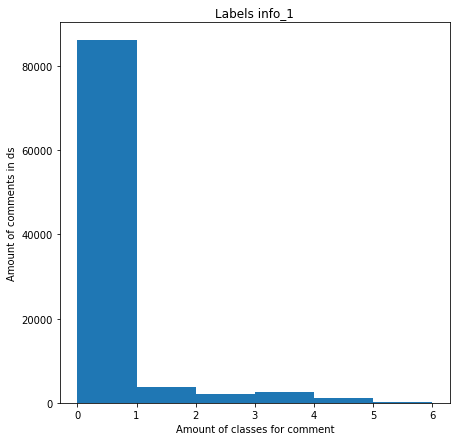

In [53]:
bins = train[classes_].sum(axis=1).unique()
bins.sort()
fig = plt.figure(figsize=(7, 7))
plt.hist(train[classes_].sum(axis=1), bins)
plt.title('Labels info_1')
plt.xlabel('Amount of classes for comment')
plt.ylabel('Amount of comments in ds')

In [47]:
train[classes_].sum(axis=0)

toxic            9237
severe_toxic      965
obscene          5109
threat            305
insult           4765
identity_hate     814
dtype: int64

In [85]:
for i in classes_:
    print('CLASS', i.upper())
    tmp = np.asarray(train[train[i] == 1].comment_text)
    print(tmp[-1])
    print()

CLASS TOXIC
ps. Almost forgot, Paine don't reply back to this shit, I don't want to see/care what you have to say do your bitching out of my sight, plskthxbai.

CLASS SEVERE_TOXIC
98.248.32.178 I will set you on fire, I will shoot your ass up. I will cut your penis off and I will shove it down your throat and choke you. I will cut you up big time motherfucker.

CLASS OBSCENE
ps. Almost forgot, Paine don't reply back to this shit, I don't want to see/care what you have to say do your bitching out of my sight, plskthxbai.

CLASS THREAT
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL You WiLL Die You PaTHeTiC FooL!
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL You WiLL Die You PaTHeTiC FooL!
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL You WiLL Die You PaTHeTiC FooL!
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL You WiLL Die You PaTHeTiC FooL!
SuPeRTR0LL WiLL LiVe FoReVeR!
iF You DoN'T ReSPeCT THe SuPeRTR0LL Yo

* Comments contain IP-addresses, user names, urls and a lot of other mess. (better to clean up with regex, etc)
* Also some comments contain lots of repetitions. 

I want to add amount of negative words as feature. Here lies dictionary: https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/blob/master/data/opinion-lexicon-English/negative-words.txt

In [135]:
neg_words = [i[:-1] for i in open('negative-words.txt')]

In [147]:
neg_words_counts = train.comment_text.apply(lambda a: len([i for i in a.lower().split() if i in neg_words]))

* Tokenizing with TweetTokenizer NLTK. (seem to be cool tool:D)

In [149]:
tt = TweetTokenizer(strip_handles=True, reduce_len=True)

In [155]:
def beautify_text(s):
    # Removes all characters from string except letters and digits and convert letters to lowercase
    s = re.sub("[^a-zA-Z0-9]", " ", s.lower())
    # Remove new lines
    s = re.sub("\\n","", s)
    # Change urls
    s = re.sub("[a-zA-Z0-9]*(https://)[a-zA-Z0-9.]*", "url", s)
    # Remove IPs
    s = re.sub("\d{1,3}.\d{1,3}.\d{1,3}.\d{1,3}","", s)
    # Remove usernames
    s = re.sub("\[\[.*\]","", s)
    # Remove numbers
    s = re.sub("\\b[0-9]+\\b", "", s)
    return s

In [158]:
beautiful_text_tr = train.comment_text.apply(beautify_text)
beautiful_text_ts = test.comment_text.apply(beautify_text)

In [169]:
words_tr = [tt.tokenize(i) for i in beautiful_text_tr]
words_ts = [tt.tokenize(i) for i in beautiful_text_ts]

In [170]:
ps = PorterStemmer()
wnl = WordNetLemmatizer()

In [171]:
words_tr = [[ps.stem(j) for j in i] for i in words_tr]
words_tr = [[wnl.lemmatize(j) for j in i] for i in words_tr]

In [172]:
words_ts = [[ps.stem(j) for j in i] for i in words_ts]
words_ts = [[wnl.lemmatize(j) for j in i] for i in words_ts]

In [173]:
words_tr = [[i for i in j if i not in stopwords.words('english')] for j in words_tr]

In [174]:
words_ts = [[i for i in j if i not in stopwords.words('english')] for j in words_ts]

In [175]:
text_train_new = [' '.join(i) for i in words_tr]
text_test_new = [' '.join(i) for i in words_ts]

* TF-IDF using n_gram from 1 to 3

In [176]:
tfv = TfidfVectorizer(min_df=50,  max_features=30000, 
            strip_accents='unicode', analyzer='word',ngram_range=(1,3),
            use_idf=1, smooth_idf=1, sublinear_tf=1,
            stop_words = 'english')

In [182]:
train_ = tfv.fit_transform(text_train_new)
test_ = tfv.transform(text_test_new)

* For embedings I'm gonna use *bag-of-means* (https://arxiv.org/pdf/1509.01626.pdf)<br>
<p>"We also have an experimental model that uses k-means on word2vec learnt from the training subset of each dataset, and then use these learnt means as representatives of the clustered words. We take into consideration all the words that appeared more than 5 times in the training subset. The bag-of-means features are computed the same way as in the bag-of-words model. "

In [187]:
model = gensim.models.Word2Vec(words_tr, min_count=100, size=500)
word_vectors = model.wv.syn0

In [194]:
kmeans_model = KMeans(n_clusters=2800)
idx = kmeans_model.fit_predict(word_vectors)
word_centroid_map = dict(zip(model.wv.index2word, idx ))

In [199]:
model.wv.similar_by_vector(kmeans_model.cluster_centers_[540])

[('fuck', 1.0),
 ('retard', 0.6874533891677856),
 ('asshol', 0.6376489400863647),
 ('motherfuck', 0.617753267288208),
 ('cunt', 0.6025792956352234),
 ('garbag', 0.5999402403831482),
 ('bitch', 0.5947405695915222),
 ('shut', 0.5876146554946899),
 ('shit', 0.5849085450172424),
 ('damn', 0.582467257976532)]

In [207]:
vector_dim = 500
embedding_matrix = np.zeros((len(kmeans_model.cluster_centers_), vector_dim))
for i in range(len(kmeans_model.cluster_centers_)):
    embedding_vector = kmeans_model.cluster_centers_[i]
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [260]:
X_train, X_eval, y_train ,y_eval = train_test_split(train_, train[classes_].values, test_size=0.2, random_state=42)

* Bidirectional LSTM

In [236]:
def model_LSTM():
    embed_size = 500
    max_features = 2800
    model_lstm = Sequential()
    model_lstm.add(Embedding(max_features, embed_size, weights=[embedding_matrix]))
    model_lstm.add(Bidirectional(LSTM(50, return_sequences=True)))
    model_lstm.add(GlobalMaxPool1D())
    model_lstm.add(Dropout(0.25))
    model_lstm.add(Dense(50, activation="relu"))
    model_lstm.add(Dropout(0.25))
    model_lstm.add(Dense(6, activation="sigmoid"))
    model_lstm.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model_lstm


In [237]:
model_1 = model_LSTM()
batch_size = 32
epochs = 2

In [254]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=20)

In [266]:
X_train.shape

(76680, 8636)

In [ ]:
model_1.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_eval, y_eval),
            callbacks=[early], verbose=0)

* Let's first try Conv+LSTM NeuralNet

 
* Using *sigmoid* on last layer instead of *softmax* 'cause we want probability of each class. So we are using sigmoid on final layer, which gives output in range 0 to 1. If our aim was to find the class, then we will have used softmax 